# Critical Research Question:
### Using government and non-profit owned housing as a proxy for affordability, is variation in the monthly counts of demolition job records predictive of changes in New York City’s shelter population over time, accounting for seasonality, from 2016 to end of 2022?

## Overview of Findings:

## We fail to reject our Null Hypothesis due to our models having a high RMSE and is unable to strongly account for New York City's shelter population.

## OVERALL: Our time-series models failed to beat our baseline model, which had a RMSE of 1,600 people in shelters. Our best model had a RMSE of 5,685 people in shelters (SARIMAX), and our worst was as high as 11,633 people in shelters(SARIMA).
    - Due to the policies implemented during the COVID pandemic, it is difficult to create an accurate time-series model that has an RMSE better than the baseline.

## RECOMMENDATIONS:
    - We recommend to continue to build affordable buildings as shown through our Tableau dashboard.
    - Further investigate into relationships that can contribute to increases in shelter count for future prevention.
    - Increase shelter capacity and homelessness prevention services to account for rise after the end of 2022.
    - Plan for contingencies in case of sudden spikes in shelter count.

### <u> DATA COLUMNS </u>
- Monthly shelter count (within DHS_Data_Dashboard) is what we're predicting.
- Exogenous variables tested:
    - <b> covid_dummy: Dummy variable (0 or 1) to highlight dates that were during covid. (USED ON SARIMAX) </b>
    - affordable_demo: Count of affordable demolitions during the month.
    - aff_demo_lag1: Count of affordable demolitions in the previous month (impact isn't immediate).
    - aff_demo_lag2: Count of affordable demolitions 2 months ago (impact isn't immediate).

### <u> DATA OVERVIEW </u>
- Both demolitions and shelter count have been aggregated on the monthly level.
    - Demolitions filtered to be "affordable housing" proxy (government,non-profit)
- Shelter count drops in 2021, rises again in 2022.
- Is stationary (constant variance in mean over time), confirmed by the AdFuller Test.
    - Null Hypothesis: The time series possesses a unit-root and is non-stationary, p-value was less than 0.05, thus we reject the null hypothesis.
- Each data point exhibits autocorrelation (dependent on each other), confirmed by ACF and PACF plots. 
    - Highlighted a correlation between lags.
- Decomposition of data showed a seasonal trend.

### <u> DECOMPOSITION </u>
- Seasonality shows a yearly cycle.
- Residuals variance appear constant, up until 2021 due to COVID policies.

### <u> TEST-TRAIN SPLIT </u>
- Train: 67 month-start records
    - 2016-01-01 to 2021-07-01
- Test: 17 month-start records
    - 2021-08-01 to 2022-12-01

### <u> LIMITATION FOR MODELS </u>
- Test data only has 17 rows.
    - Limits amount of lags being used (1-3 total).
    - Limits predictive performance.
- Adding more lags either isn't statistically significant in the .summary or model doesn't converge (come to a finite end).

### <u> BASELINE MODEL </u>
- Shift one baseline model.
    - Uses previous time point in our monthly sample to predict the current time point.
- Concluded with an RMSE of about 1,600 (predictions are off by about 1,600 people)

### <u> ARIMA MODEL </u>
- Decided on a (p,d,q) of p = 1, d = 0, q = 1.
    - Due to adfuller confirming the alternate hypothesis of the data being stationary, we decided no differencing.
    - ARIMA (1,0,1) has an RMSE: 6,581.286 (sheltercount off by 6,581 people).

    - DIAGNOSTIC
        - Convergence = True
            - Model reaches a finite amount and not infinity, means we can trust the model's results.
        - PACF and ACF of residuals show no significant autocorrelation.
        - Ljung-Box test fails to reject the Null Hypothesis with lags of 12.
            - Null Hypothesis (H0): The residuals are independently distributed (no autocorrelation).

### <u> SARIMA MODEL </u>
- (p,d,q) the adjusted for 2-3 total lags including seasonal (P, D, Q)
    - ARIMA = p = 1, d = 0, q = 0
    - SEASONAL = P = 1, D = 0, Q = 0, s = 12
        - SARIMA(1,0,0) (1,0,0,12) has an RMSE: 11,633.906 (shelter count off by 11,634 people).
    - DIAGNOSTIC
        - Convergence = True
        - PACF and ACF of residuals show all lags falling within X = 0 and within confidence interval.
        - Ljung-Box test fails to reject the Null Hypothesis with lags of 12.

### <u> SARIMAX MODEL </u>
- Endogenous variable of 'COVID Dummy' to account for drops and spikes of shelter count during COVID.
- ARIMA = p = 1, d = 0, q = 0
- SARIMA = P = 1, D = 1, Q = 0, s = 12
    - SARIMAX (1,0,0) (1, 1, 0, 12) has an RMSE: 5,685.164 (shelter count off by 5,685 people)
    - DIAGNOSTIC
        - Convergence = True
        - PACF and ACF of residuals show all lags falling within X = 0 and within confidence interval.
        - Ljung-Box test fails to reject the Null Hypothesis with lags of 12.

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


# connecting to SQL databasee "nyc_demolition.db"
DB_PATH = '/Users/beans/Desktop/TeamHousing/data/processed/nyc_demolitions.db'
HOUSING_PATH = '/Users/beans/Desktop/TeamHousing/data/HousingDB_post2010.csv'
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# SQL READS include WHERE clause to filter dates
# reading construction/demolition data
queryowner_demo = """
SELECT *
FROM fact_demolitions f
WHERE month_date BETWEEN '2016-01-01' AND '2023-01-01'
"""

fact_owner_demo = pd.read_sql_query(queryowner_demo, conn)

# reading shelter data
queryshelter = """
SELECT *
FROM fact_shelters
WHERE report_date BETWEEN '2016-01-01' AND '2023-01-01'
"""
fact_shelter = pd.read_sql_query(queryshelter, conn)

# setting job_typeid to strings to represent what the job done is
mapdemo = {1:'construction',2:'demolition'}
fact_owner_demo['job_typeid'] = fact_owner_demo['job_typeid'].map(mapdemo)

# setting ownership_id 1 to private and 2/3 to affordable (government & nonprofit)
mapowner = {1:'private',2:'affordable',3:'affordable'}
fact_owner_demo['ownership_id'] = fact_owner_demo['ownership_id'].map(mapowner)

# displaying both databases for visuals
display('Construction/Demolition Data (.head):',fact_owner_demo.sort_values(by=['bin'],ascending=False).head())
display('Shelter Count Data: (.head)',fact_shelter.sort_values(by=['report_date'],ascending=False).head())

'Construction/Demolition Data (.head):'

,month_date,bin,job_typeid,ownership_id,borough,date_filed,date_completed,time_of_completion
10466,2018-08-01 00:00:00,5867189,demolition,private,Staten Island,2018-06-21 00:00:00,2018-08-03 00:00:00,43
10464,2018-09-01 00:00:00,5867187,demolition,private,Staten Island,2018-06-21 00:00:00,2018-09-24 00:00:00,95
10463,2018-11-01 00:00:00,5867186,demolition,private,Staten Island,2018-06-21 00:00:00,2018-11-26 00:00:00,158
10462,2018-11-01 00:00:00,5867185,demolition,private,Staten Island,2018-06-21 00:00:00,2018-11-26 00:00:00,158
10621,2017-10-01 00:00:00,5866758,demolition,private,Staten Island,2017-09-28 00:00:00,2017-10-31 00:00:00,33


'Shelter Count Data: (.head)'

,report_date,shelter_count
0,2022-12-01 00:00:00,44958
1,2022-11-01 00:00:00,42338
2,2022-10-01 00:00:00,41852
3,2022-09-01 00:00:00,39541
4,2022-08-01 00:00:00,35811


In [104]:
# copying shelter SQL read to further clean without adjust original data
shelter = fact_shelter.copy()

shelter['report_date'] = pd.to_datetime(shelter['report_date'])

#shelter has some duplicate dates
shelter['report_date'].value_counts()
shelter = shelter.drop_duplicates(subset=['report_date'])

# renaming to be able to merge
shelter= shelter.rename(mapper={'report_date':'month_date'},axis=1)
shelter = shelter.sort_values(by='month_date',ascending=True)

# setting index as monthly dates for our models
s = shelter.set_index(shelter['month_date'])['shelter_count'].asfreq('MS')

In [105]:
# performing ADFuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(s)
print(f"p value is: {adf_result[1]:.10f}")

# p value is less than 0.05, indicating stationarity

p value is: 0.0008886791


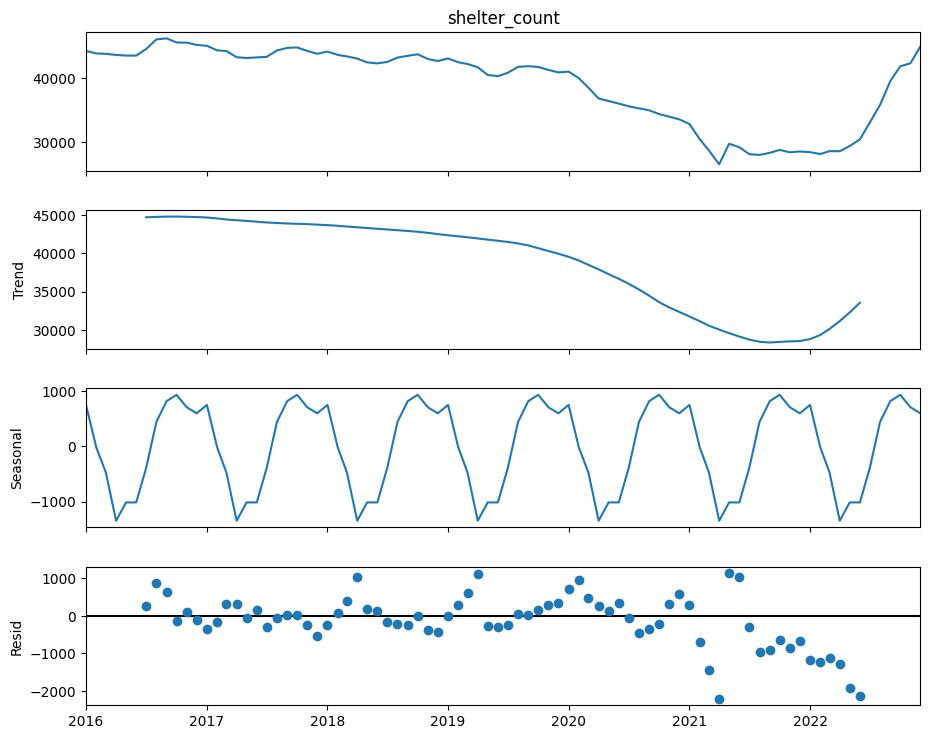

In [106]:
# decompose the time series (assuming a 12-month cycle)
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(s, model='additive', period=12)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.show()

# dip between 2021 and 2022, raises through 2022 to 2023

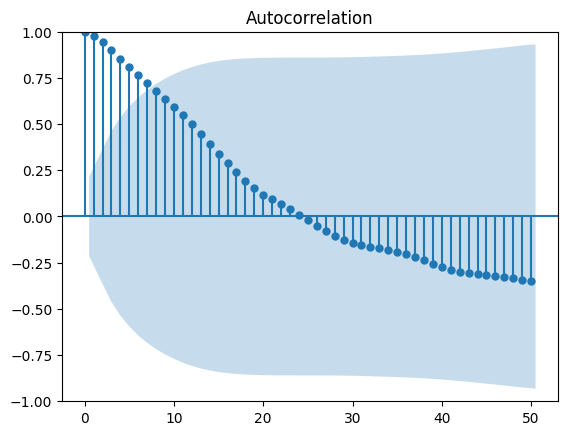

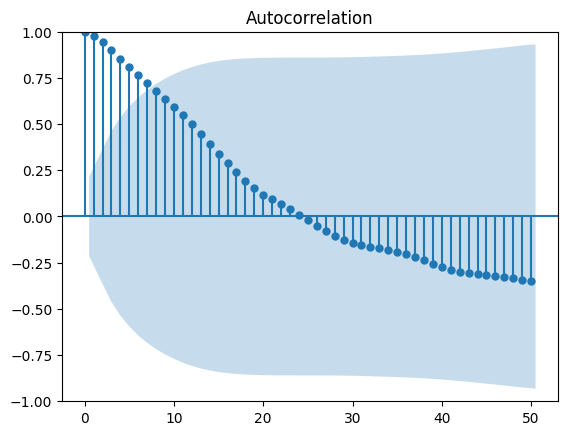

In [107]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#shows moving average for time series lags
plot_acf(s, lags=50)

# picking MA to be 7 as our plot shows our lag at 7 is significant

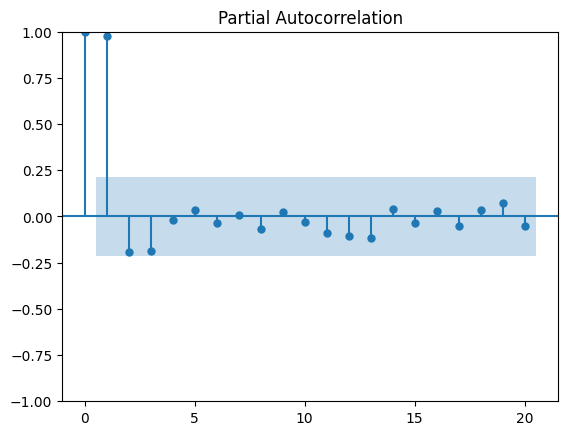

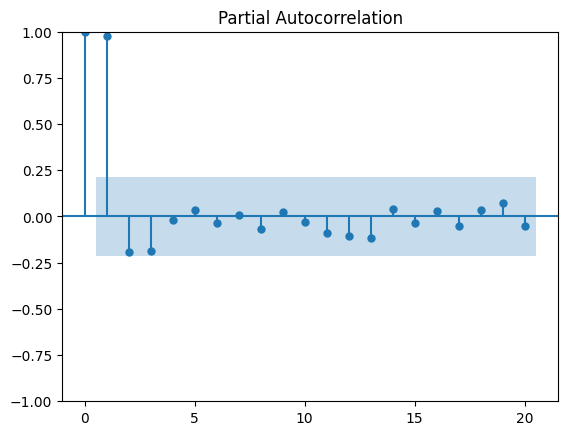

In [108]:
plot_pacf(s)

#peaks at 1, each previous lag has a significant impact on the next value

# BASELINE MONTHLY

In [109]:
# train test splits
splitbaseline = int(len(s) * 0.80)

split = int(len(s) * 0.8)
train = s.iloc[:split]
test = s.iloc[split:]

# training predictions & actual
train_actual = train.iloc[1:]
train_pred = train.shift(1).dropna()


In [110]:
# baseline prediction is using the previous value of train + test as the way to predict the next value
# test predicts
test_pred = pd.Series(index=test.index,dtype=float)

#test of test vs last observed train
test_pred.iloc[0] = train.iloc[-1]

for i in range (1,len(test)):
    test_pred.iloc[i] = test.iloc[i-1]

# output is a test_prediction that takes the last training value
# and all values going forward lags one behind

Baseline RMSE: 1,599.587


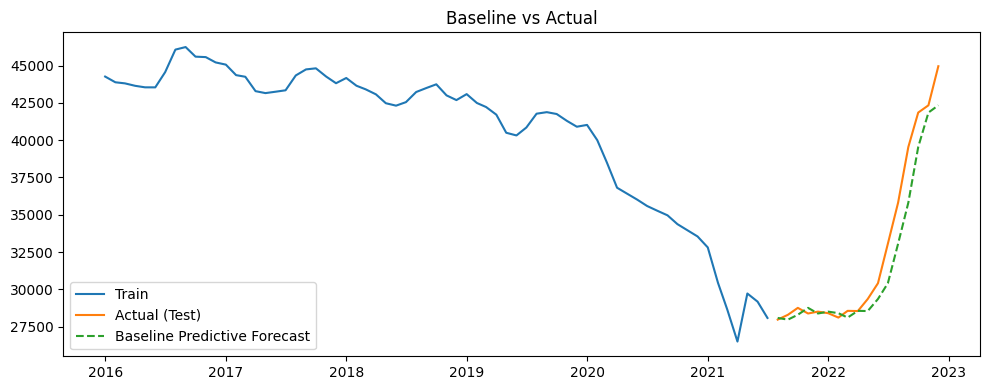

In [111]:
# checking RMSE to find error in our predictions in the same unit
rmse_baseline = np.sqrt(mean_squared_error(test,test_pred))


print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(test_pred, label="Baseline Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title('Baseline vs Actual')
plt.legend()
plt.tight_layout()
plt.show()


### With our RMSE being about 1,599.587, our baseline forecast is off by about 1,600 people counted in the shelter.

# <u> ARIMA (MONTHLY) </u>

In [112]:
# train test splits
splitarima = int(len(s) * 0.80)
# 80% of the data
trainarima = s.iloc[:splitarima]
# 20% of the data
testarima  = s.iloc[splitarima:]

In [113]:
from statsmodels.tsa.arima.model import ARIMA

arimamodel = ARIMA(trainarima, order=(1,0,1))
arimamodel_fit = arimamodel.fit()

# --- 3. Make Predictions ---
# Forecast the next 12 periods
predictionarima = arimamodel_fit.forecast(steps=len(testarima))

arimamodel_fit.summary()
# ar lag 1 with a coefficient of 0.9922 means its ALMOST not stationary

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          shelter_count   No. Observations:                   67
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -546.241
Date:                Tue, 24 Feb 2026   AIC                           1100.482
Time:                        02:20:10   BIC                           1109.301
Sample:                    01-01-2016   HQIC                          1103.972
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.064e+04   2.06e+04      1.968      0.049     171.185    8.11e+04
ar.L1          0.9922      0.020     49.421      0.000       0.953       1.032
ma.L1          0.2503      0.082      3.047      0.002       0.089       0.411
sigma2      6.585e+05   7.22e+04      9.117      0.000    5.17e+05       8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               143.08
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               5.56   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### We are only considering stationarity in stochastic trends (permanent trend changes) and not deterministic ones, thus we disregard the warning above and did not difference.

Explanation of Coefficients
    - const: at baseline, we can expect 40,640 people in the shelter. <br>
    - ar.L1: shelter population is 99.22% explained by last month's shelter population. <br>
    - ma.L1: last months unexpected change in shelter counts impacts the next by 25.03%. <br>
    - sigma2: there is still about 658,500 variance in shelter count within the residuals in our training set model.

Arima (1,0,1) RMSE: 6,581.286


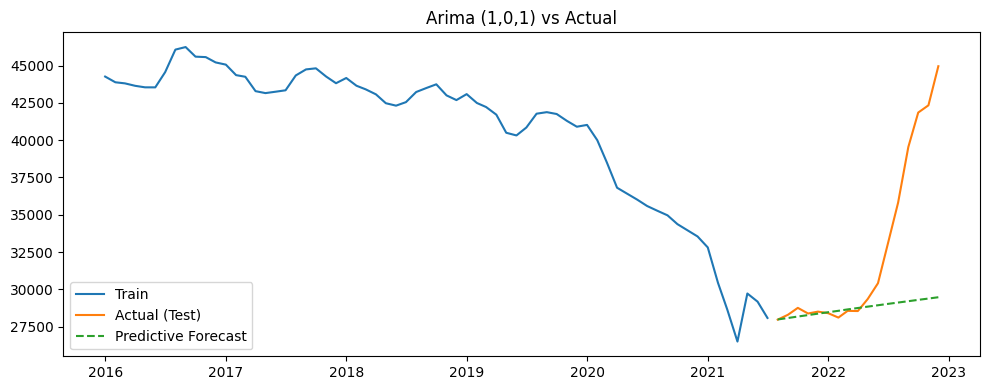

In [114]:
arima_rmse = np.sqrt(mean_squared_error(testarima, predictionarima))

print(f"Arima (1,0,1) RMSE: {arima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(trainarima, label="Train")
plt.plot(testarima, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictionarima, label="Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("Arima (1,0,1) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

### Our ARIMA (1,0,1) model's RMSE is 6,581.286, signifying that our model's outputs have an error of about 6,581 people.

### <u> diagnostic for ARIMA </u>

In [115]:
arimamodel_fit.mle_retvals

# converged is True (model reaches a finite amount and not infinity) means we can trust the model's results

{'fopt': 8.15285282418691,
 'gopt': array([ 1.01447705e-06, -2.29949393e-06, -2.39701592e-06, -5.05195886e-07]),
 'fcalls': 160,
 'warnflag': 0,
 'converged': True,
 'iterations': 30}

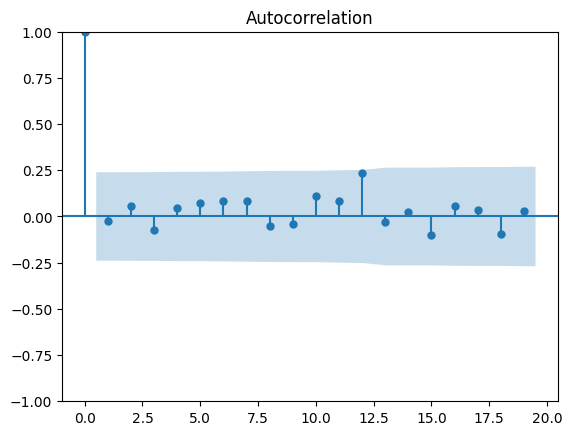

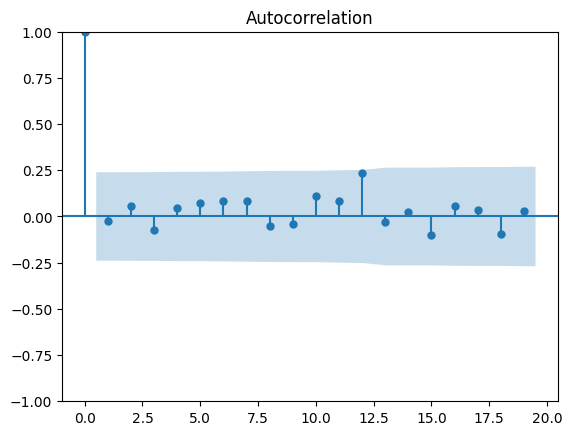

In [116]:
plot_acf(arimamodel_fit.resid)

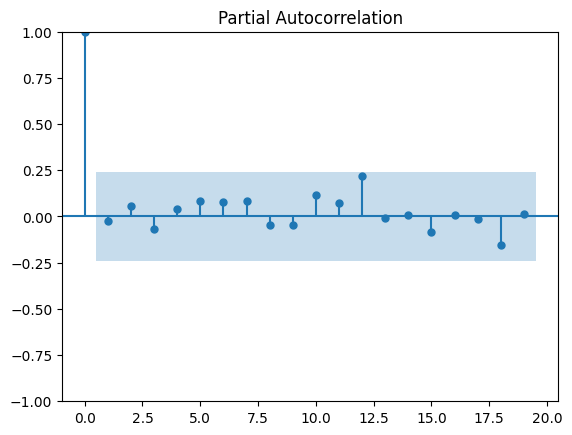

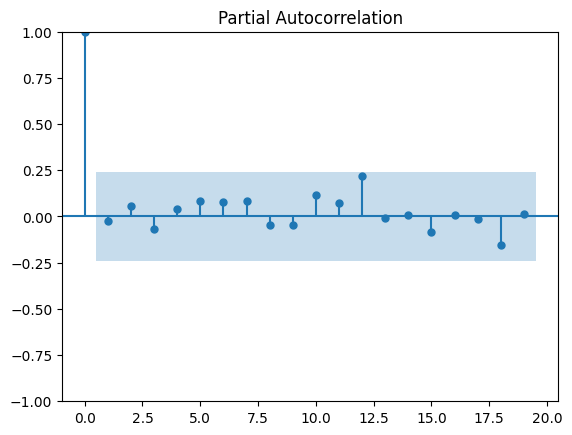

In [117]:
plot_pacf(arimamodel_fit.resid)

In [118]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# ljung-box test

# Null Hypothesis (H0): The residuals are independently distributed (no autocorrelation).
#Alternative hypothesis (H₁):The residuals are not independent — there is autocorrelation at one or more lags.
lb_test_results = acorr_ljungbox(arimamodel_fit.resid, lags=[12], return_df=True)
lb_test_results

#residuals do not reject the null hypothesis meaning there is no autocorrelation (what we're looking for for model residuals)

,lb_stat,lb_pvalue
12,8.787301,0.720982


### All of our ARIMA's residuals lags fall within the confidence interval, highlighting the model's assumptions are met and no significant remaining correlations.

In [138]:
joblib.dump(arimamodel_fit,'baseline_model.pkl')

['baseline_model.pkl']

# SARIMA (monthly)

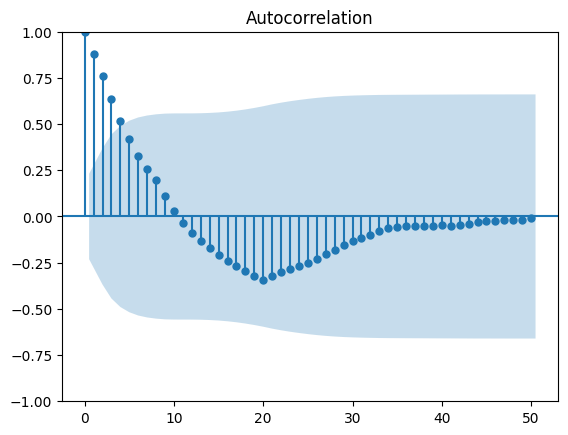

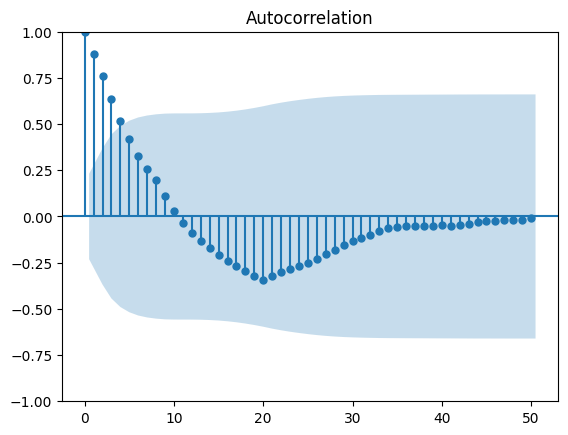

In [119]:
# differencing data (D = 12) to find if any seasonal attribute/ P and Q for SARIMA
diff_s = s.diff(12).dropna()

plot_acf(diff_s, lags=50)

# we see the seasonal component is within the confidence interval, meaning that it is not statistically significant after differencing
# Q seems to be 1-4, right before falling into confidence interval (is statistically significant)

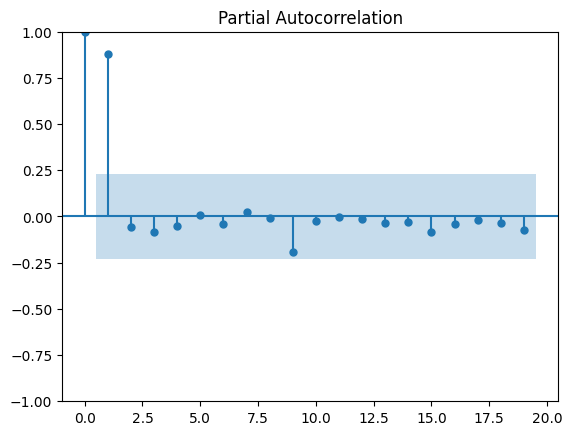

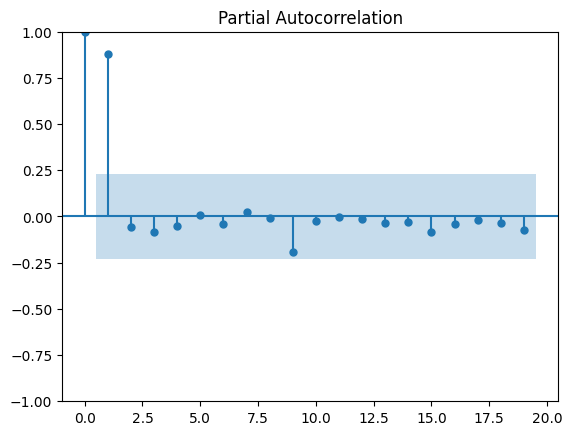

In [120]:
plot_pacf(diff_s)
# P is one, spike on first

In [121]:
# train test splits
splitSarima = int(len(s) * 0.80)
# 80% of the data
trainSarima = s.iloc[:splitSarima]
# 20% of the data
testSarima  = s.iloc[splitSarima:]

In [122]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
modelSarima = SARIMAX(
    trainSarima,
    # so far has been the best order, adding a MA performs the same but MA is not significant
    order=(1, 0, 0),        # ARIMA part: p, d, q
    # s of 12 due to original decomposition plot showing the seasonal cycle repeats every year
    # D of 1 makes PACF and ACF have spikes in lags.
    seasonal_order=(1, 0, 0, 12),
    enforce_stationarity=True
)
Sarimamodel_fit = modelSarima.fit()

Sarimamodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      shelter_count   No. Observations:                   67
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -539.497
Date:                            Tue, 24 Feb 2026   AIC                           1084.994
Time:                                    02:20:11   BIC                           1091.608
Sample:                                01-01-2016   HQIC                          1087.611
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9980      0.004    234.959      0.000       0.990       1.006
ar.S.L12       0.6784      0.120      5.661      0.000       0.444       0.913
sigma2       4.61e+05   3.43e+04     13.449      0.000    3.94e+05    5.28e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               391.77
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               5.13   Skew:                             2.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explanation of Coefficients: <br>
    - ar.L1: shelter population is 99.80% explained by last month's shelter population. <br>
    - ar.S.L12: last year's shelter population accounts for 67.84% of this year's shelter population. <br>
    - sigma2: there is still about 461,000 variance within the residuals in our training set model.

Sarima (1,0,0) (1,0,0,12) RMSE: 11,004.713


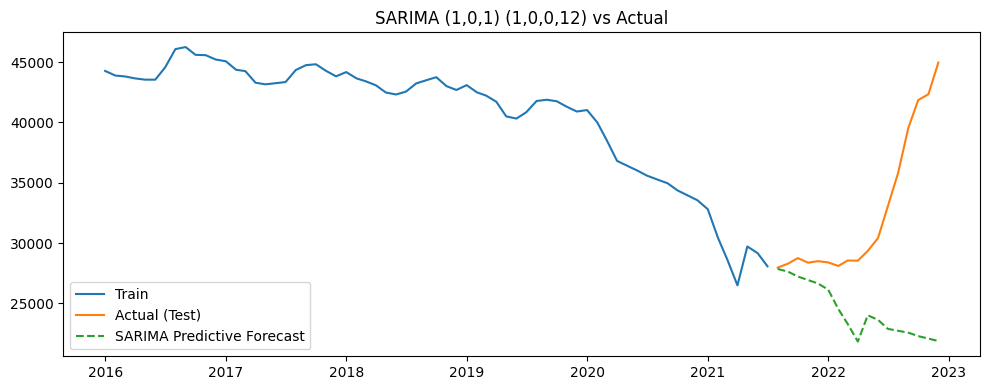

In [123]:
predictionSarima = Sarimamodel_fit.forecast(steps=len(testSarima))
sarima_rmse = np.sqrt(mean_squared_error(testSarima, predictionSarima))

print(f"Sarima (1,0,0) (1,0,0,12) RMSE: {sarima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(trainSarima, label="Train")
plt.plot(testSarima, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictionSarima, label="SARIMA Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("SARIMA (1,0,1) (1,0,0,12) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

### diagnostic

In [124]:
Sarimamodel_fit.mle_retvals

# converged is True (model reaches a finite amount and not infinity) means we can trust the model's results

{'fopt': 8.052193456835006,
 'gopt': array([ 1.91668903e-07, -5.52340396e-06, -1.15463195e-08]),
 'fcalls': 232,
 'warnflag': 0,
 'converged': True,
 'iterations': 30}

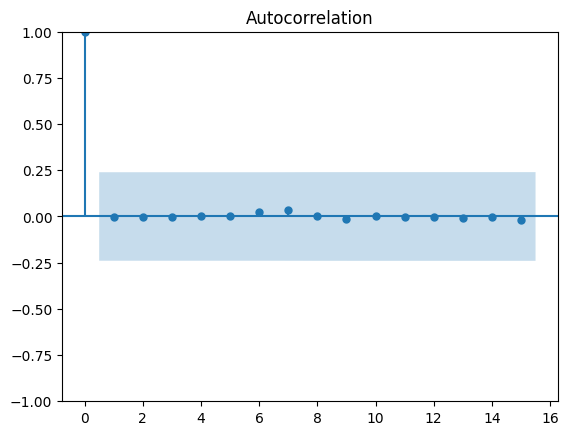

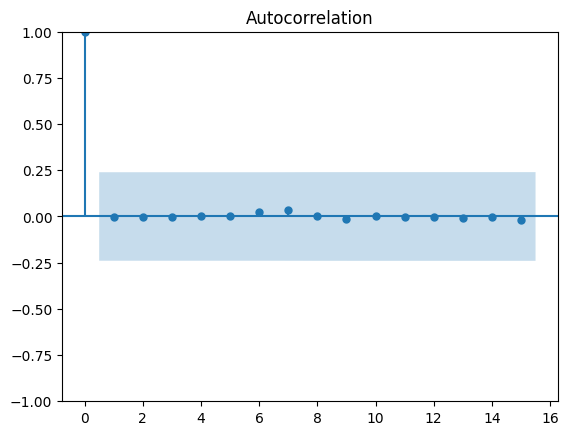

In [125]:
plot_acf(Sarimamodel_fit.resid, lags=15)

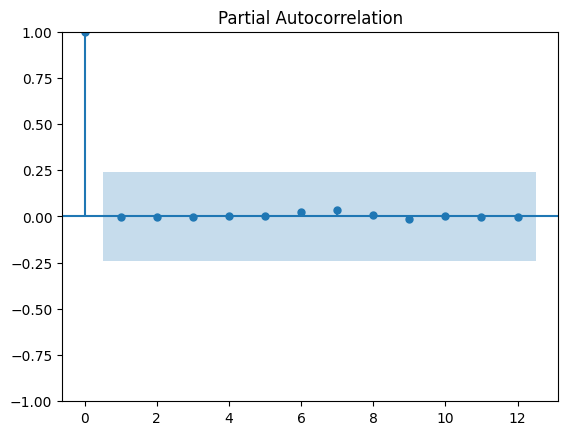

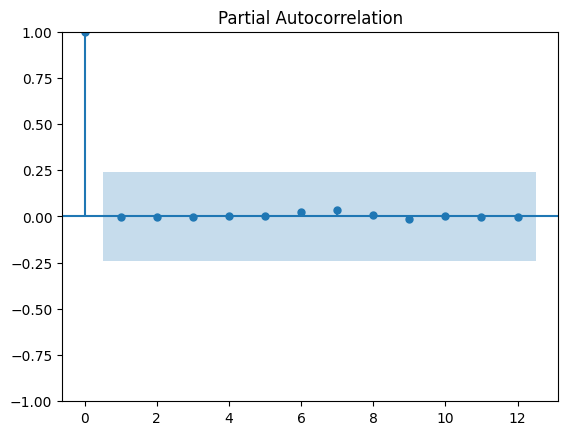

In [126]:
plot_pacf(Sarimamodel_fit.resid,lags=12)

In [127]:
lb_test_results = acorr_ljungbox(Sarimamodel_fit.resid, lags=[12], return_df=True)
lb_test_results

,lb_stat,lb_pvalue
12,0.174113,1.0


In [137]:
joblib.dump(Sarimamodel_fit,'sarima_model.pkl')

['sarima_model.pkl']

# SARIMAX (monthly)

In [ ]:
sarimaXdata = fact_owner_demo.copy()

# copying data, subsetting to only have these columns
sarimaXdata = sarimaXdata[['month_date','job_typeid','ownership_id']]
# filtering to be only affordable demolitions
sarimaXdata = sarimaXdata[(sarimaXdata['ownership_id'] == 'affordable') & (sarimaXdata['job_typeid'] == 'demolition')]

# making data chronological
sarimaXdata.sort_values(by='month_date',ascending=False)
sarimaXdata['month_date'] = pd.to_datetime(sarimaXdata['month_date'])

# grouping by month_date to count amount of demolitions
sarimaxdata = sarimaXdata.groupby('month_date').agg({'job_typeid':'count'})

# create an empty df to merge with original data and have all months (even ones with 0 demolitions)
empty = pd.date_range(start='2016-01-01',end='2022-12-01',freq='MS')
datedf = pd.DataFrame(data=empty)

datedf = datedf.rename(mapper={0:'month_date'},axis=1)
# merging with sarimax_data
datedf = datedf.merge(sarimaxdata,how='left',on='month_date')
datedf = datedf.fillna(0)

# complete merge of dates, counts of affordable demolitions and shelter counts
datedf = datedf.merge(shelter,how='left',on='month_date')

# having months be index for our SARIMAX model
#datedf.set_index(keys='month_date')

datedf = datedf.rename(mapper={'job_typeid':'affordable_demo'},axis=1)
datedf.set_index("month_date",inplace=True)

# CHATGPT CODE TO ADD 'covid_dummy' AS A INTERACTION TERM TO ACCOUNT FOR COVID SPIKE (exog variable)
# Initialize COVID dummy as 0
datedf['covid_dummy'] = 0
# Set to 1 for months affected by COVID (March 2020 – December 2021)
datedf.loc['2020-03-01':'2021-12-01', 'covid_dummy'] = 1

# CHATGPT CODE TO THINK ABOUT HOW DEMO PROBABLY DOESN'T AFFECT SHELTER COUNT IMMEDIATELY (exog variable)
# assuming demolitions aren't giving an immediate impact, but a 1/2 month lag effect
datedf['aff_demo_lag1'] = datedf['affordable_demo'].shift(1).fillna(0)  # 1 month lag
datedf['aff_demo_lag2'] = datedf['affordable_demo'].shift(2).fillna(0)  # 2 month lag

datedf = datedf.resample(rule='MS').sum()
datedf.to_csv('datedf.csv', index=Tre)

In [164]:
# train test splits (including exogenous variable)
splitSarimaX = int(len(s) * 0.80)
# 80% of the data
trainSarimax = datedf['shelter_count'].iloc[:splitSarimaX]
trainexogSarimax = datedf[['covid_dummy']].iloc[:splitSarimaX]
# 30% of the data
testSarimax  = datedf['shelter_count'].iloc[splitSarimaX:]
testexogx = datedf[['covid_dummy']].iloc[splitSarimaX:]

In [165]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
# same as SARIMA, except include endog variable
modelSarimax = SARIMAX(
    trainSarimax,
    # exog variable is ['affordable_demo'] column
    exog=trainexogSarimax,
    order=(1, 0, 0),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 0, 12),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
)
resultsSarimax = modelSarimax.fit()

resultsSarimax.summary()
# covid_dummy was able to recognize the drop in shelter count, doesn't really understand spike as it is not in training data
# affordable_demo : -54.1314 coef
# aff_demo_lag1 : 40.1006 coef
# aff_demo_lag2 : 38.2014 coef

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      shelter_count   No. Observations:                   67
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -359.428
Date:                            Tue, 24 Feb 2026   AIC                            726.855
Time:                                    13:29:54   BIC                            733.806
Sample:                                01-01-2016   HQIC                           729.403
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid_dummy -6294.3329    621.443    -10.129      0.000   -7512.340   -5076.326
ar.L1           0.9702      0.060     16.205      0.000       0.853       1.088
ar.S.L12       -0.8776      0.163     -5.375      0.000      -1.198      -0.558
sigma2       1.748e+06   4.69e+05      3.730      0.000     8.3e+05    2.67e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               155.72
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):              12.80   Skew:                             2.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Explanation of Coefficients: <br>
    - covid_dummy: during COVID, shelter count dropped by 6,294 people. <br>
    - ar.L1: shelter population is 97.02% explained by last month's shelter population. <br>
    - ar.S.L12: last year’s value strongly predicts this year, but in the opposite direction: a high last year predicts a low this year. <br>
    - sigma2: after including last month, last year, and covid effects, there is still about 1,748,000 variance within the residuals in our training set model.


Sarimax (1,0,0) (1, 1, 0, 12) RMSE: 5,685.164


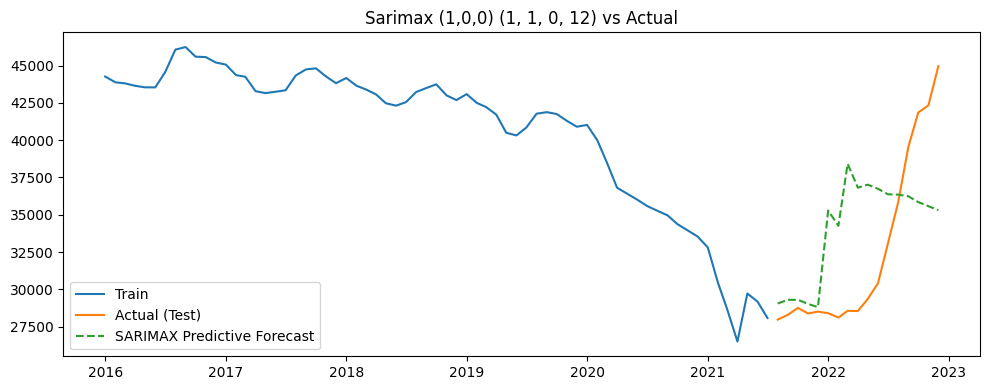

In [166]:
predx = resultsSarimax.get_forecast(steps=len(testSarimax),exog=testexogx)
predictionsx = predx.predicted_mean
sarima_rmsex = np.sqrt(mean_squared_error(testSarimax, predictionsx))

print(f"Sarimax (1,0,0) (1, 1, 0, 12) RMSE: {sarima_rmsex:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(trainSarimax, label="Train")
plt.plot(testSarimax, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictionsx, label="SARIMAX Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("Sarimax (1,0,0) (1, 1, 0, 12) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

### <u> DIAGNOSTICS </u>

In [167]:
resultsSarimax.mle_retvals

{'fopt': 5.3645898877719365,
 'gopt': array([-4.21870549e-05, -1.07779563e-05,  4.08295620e-07,  4.57579753e-05]),
 'fcalls': 35,
 'warnflag': 0,
 'converged': True,
 'iterations': 5}

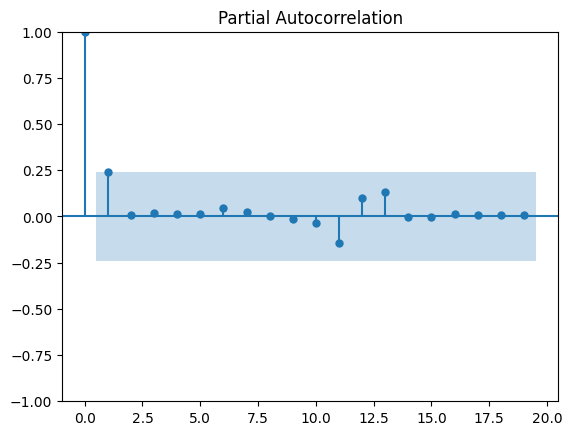

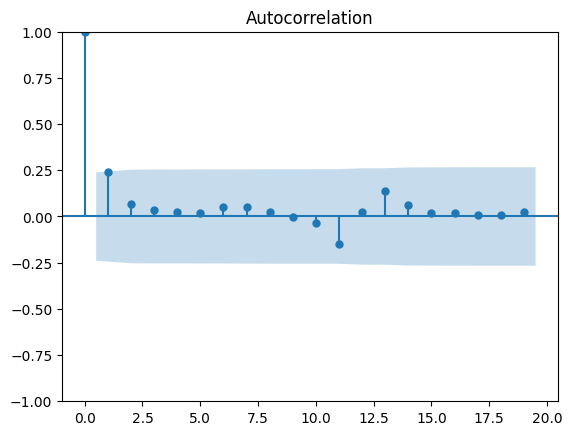

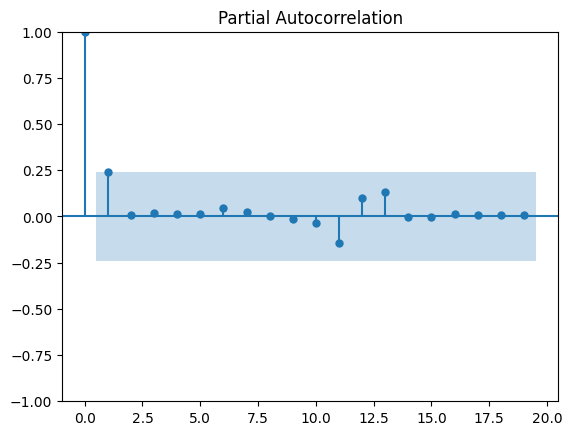

In [168]:
#plotting residuals to see if any spikes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(resultsSarimax.resid)
plot_pacf(resultsSarimax.resid)

# increasing P or Q increases the spike at lag 12, so reason is due to irregular events (covid)

In [169]:
lb_test_results = acorr_ljungbox(resultsSarimax.resid, lags=[12], return_df=True)
lb_test_results

,lb_stat,lb_pvalue
12,6.950482,0.860868


In [136]:
# save as pickle

joblib.dump(resultsSarimax,'sarimax_model.pkl')

['sarimax_model.pkl']